In [59]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import numpy as np
import math
import random
import tensorflow as tf

def binarySampleVsParity(row,column):
    
    binary = np.zeros((row,column),dtype = float)
    parity = np.zeros((row,column),dtype = float)
    
    for j in range(column):
        for i in range(row):
            
            random = np.random.randint(0,2)
            binary[i][j] = random
            
            if(j == 0):
                parity[i][j] = binary[i][j]
            elif( parity[i][j-1] == 0 and binary[i][j] == 1 ):
                parity[i][j] = 1
            elif( parity[i][j-1] == 0 and binary[i][j] == 0 ):
                parity[i][j] = 0
            elif( parity[i][j-1] == 1 and binary[i][j] == 0 ):
                parity[i][j] = 1
            elif( parity[i][j-1] == 1 and binary[i][j] == 1 ):
                parity[i][j] = 0
      
     # binary = torch.from_numpy(binary)
     # parity = torch.from_numpy(parity)
    
     # binary = tf.tuple(binary)
     # parity = tf.tuple(parity)
    
    # another Good implementation for above!
    # since some attributes in tensorflow is a bit ambitios ...
    
    binary = []
    parity = []

    for i in range(row):
        binary.append(torch.randint(0, 2, [1, column]).float())
        parity.append(torch.zeros([1, column]))
        parity[i][0][0] = binary[i][0][0]

        for j in range(1, column):
            parity[i][0][j] = ((parity[i][0][j - 1] + binary[i][0][j]) % 2).clone().detach().requires_grad_(True)
    
    binary = torch.cat(binary,0)
    parity = torch.cat(parity,0)
    
    return binary,parity

class ParityRecursiveNeuralNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(ParityRecursiveNeuralNetwork, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        self.act = nn.Tanh()

        self.loss_log = []
        self.neuron_log = []
        self.hidden_neurons = []
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        return

    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        self.hidden_neurons = hidden
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, self.output_size)
        return pred
        
        # as the doc reminds Us
        # for the recursive neural networks we have
        # st = f(Uxt + Wst−1) 
        # ot = f′(V st)
        # now x is ot and h is st
        
        # st = f(Uxt + Wst−1)
        # ot = f′(V st)

    def train(self, inputs, targets, epoches, learning_rate):  
         
        # I use this part from the GitHub : https://github.com/jcjohnson/pytorch-examples
        # and this Github : https://github.com/synxlin/nn-compression
        # criterion and optimizer both used in this github so I used them in order to enhance the
        # quality of the neuralNetwork and its betterConvergance
        
        print('\n learningData:', learning_rate)
        print(' batch size = ', inputs.shape[0] # reshaping the input in order to print it ...
              , '\n epoches = ', epoches)
        print('hidden size = ', self.hidden_size)

        
        # i used this optimizers according to this githubs
        predictions = []
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        loss_func = nn.L1Loss()

        for t in range(epoches + 1):
            inp = Variable(torch.Tensor(inputs.reshape((inputs.shape[0], -1, self.input_size))), requires_grad=True)
            out = Variable(torch.Tensor(targets.reshape((targets.shape[0], -1, self.input_size))))

            pred = self(inp)
            optimizer.zero_grad()
            predictions.append(pred.data.numpy())
            loss = loss_func(pred, out)
            self.log(float(loss), self.hidden_neurons)
            loss.backward()
            optimizer.step()

        return

    # saving Data in order to get the calculated data ...
    # logData contains neuron Data and loss Data ...
    
    def log(self, loss, neuron):
        self.loss_log.append(loss)
        self.neuron_log.append(neuron.data.numpy())
        return

    def logData(self):
        return self.loss_log, self.neuron_log


In [60]:
"""
        Training ParityRecursiveNeuralNetwork      
        ...
"""

inpSize = 1
hidSize = 6
outSize = 1
parityRecursiveNeuralNetwork = ParityRecursiveNeuralNetwork(inpSize, hidSize, outSize)

inputs, targets = binarySampleVsParity(100, 10)
parityRecursiveNeuralNetwork.train(inputs, targets, 10000, 0.0003)
print(parityRecursiveNeuralNetwork(torch.Tensor(inputs[0].reshape((1, -1, inpSize)))), targets[0])



 learningData: 0.0003
 batch size =  100 
 epoches =  10000
hidden size =  6
tensor([[[0.9984],
         [0.9992],
         [0.9994],
         [0.9994],
         [0.9997],
         [0.9997],
         [0.9995],
         [0.9997],
         [0.9997],
         [0.9995]]], grad_fn=<ViewBackward>) tensor([1., 1., 1., 1., 0., 1., 1., 0., 1., 1.], grad_fn=<SelectBackward>)


In [61]:
"""
 
        Learning rate effect
        L1loss
        
"""
inputs, targets = binarySampleVsParity(800, 10)

inpSize = 1
hidSize= 60
num_layers = 1

learningDataEffectData = []
epochs = 2000
learning_rates = [0.0005, 0.0010,0.0020,0.004,0.008, 0.0050, 0.010, 0.050, 0.1]

for i in range(9):
    learningDataEffectData.append(ParityRecursiveNeuralNetwork(inpSize, hidSize, 1))
    learningDataEffectData[i].train(inputs, targets, epochs, learning_rates[i])



 learningData: 0.0005
 batch size =  800 
 epoches =  2000
hidden size =  60

 learningData: 0.001
 batch size =  800 
 epoches =  2000
hidden size =  60

 learningData: 0.002
 batch size =  800 
 epoches =  2000
hidden size =  60

 learningData: 0.004
 batch size =  800 
 epoches =  2000
hidden size =  60

 learningData: 0.008
 batch size =  800 
 epoches =  2000
hidden size =  60

 learningData: 0.005
 batch size =  800 
 epoches =  2000
hidden size =  60

 learningData: 0.01
 batch size =  800 
 epoches =  2000
hidden size =  60

 learningData: 0.05
 batch size =  800 
 epoches =  2000
hidden size =  60

 learningData: 0.1
 batch size =  800 
 epoches =  2000
hidden size =  60


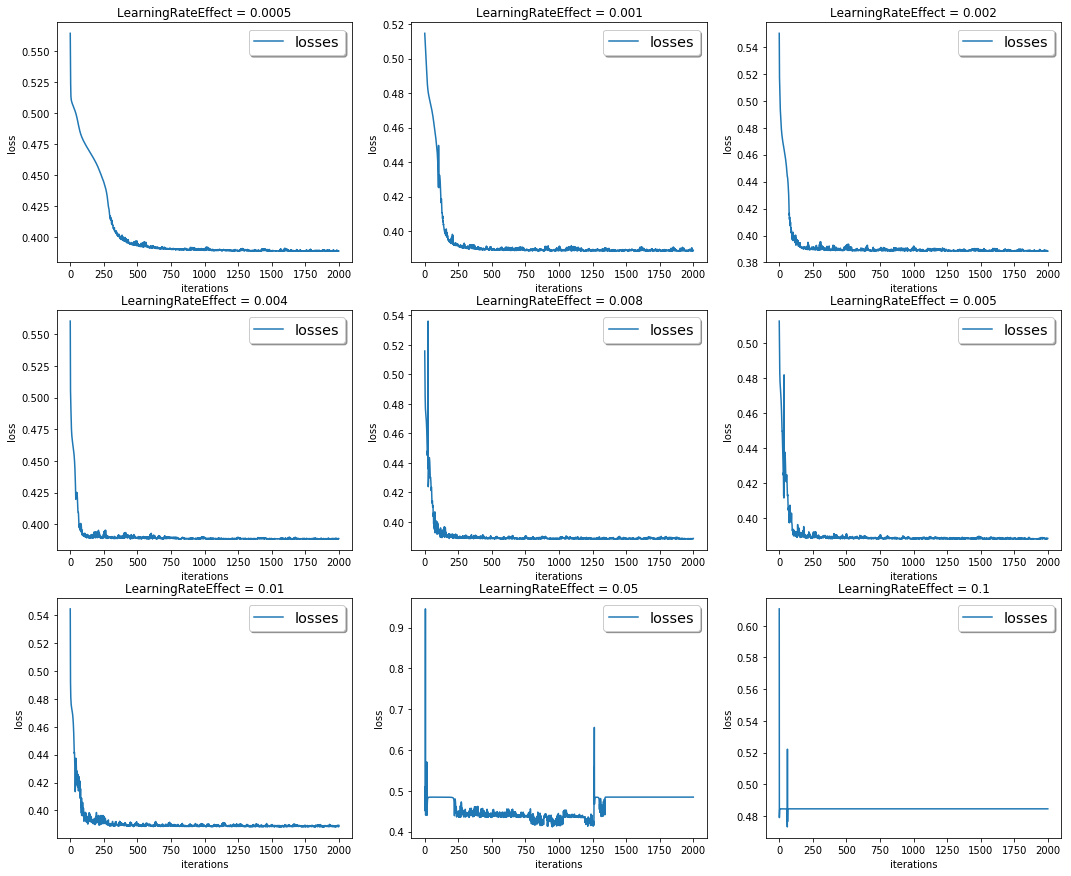

In [65]:
"""
        plots of learning rate effect
"""
from matplotlib import pyplot as plt


for i in range(9):
    
    lossData, neuronData = learningDataEffectData[i].logData()
    # neuronData is not used here --> last part neuron graph

    plt.subplot(3, 3, i+1)
    plt.plot(lossData, label='losses')
    plt.title('LearningRateEffect = {}'.format(learning_rates[i]))
    plt.legend(prop={'size':  30}, shadow=True, fontsize='x-large', loc='lower left')
    legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.xlabel('iterations')
    plt.ylabel('loss')

    
plt.gcf().set_size_inches(18, 15)
plt.show()
    


In [66]:
"""

        Batch size effect
        L1loss
        
"""
inputs, targets = binarySampleVsParity(800, 10)

input_dim = 1
hidden_size_net = 10
num_layers = 1

batchSizeEffectData = []
epoches = 2000
learning_rate = 0.003
batch_sizes = [5,10, 20,40,80,160,320,640,1024]

for i in range(9):
    batchSizeEffectData.append(ParityRecursiveNeuralNetwork(input_dim, hidden_size_net, 1))
    batchSizeEffectData[i].train(inputs[:batch_sizes[i]], targets[:batch_sizes[i]], epoches, learning_rate)



 learningData: 0.003
 batch size =  5 
 epoches =  2000
hidden size =  10

 learningData: 0.003
 batch size =  10 
 epoches =  2000
hidden size =  10

 learningData: 0.003
 batch size =  20 
 epoches =  2000
hidden size =  10

 learningData: 0.003
 batch size =  40 
 epoches =  2000
hidden size =  10

 learningData: 0.003
 batch size =  80 
 epoches =  2000
hidden size =  10

 learningData: 0.003
 batch size =  160 
 epoches =  2000
hidden size =  10

 learningData: 0.003
 batch size =  320 
 epoches =  2000
hidden size =  10

 learningData: 0.003
 batch size =  640 
 epoches =  2000
hidden size =  10

 learningData: 0.003
 batch size =  800 
 epoches =  2000
hidden size =  10


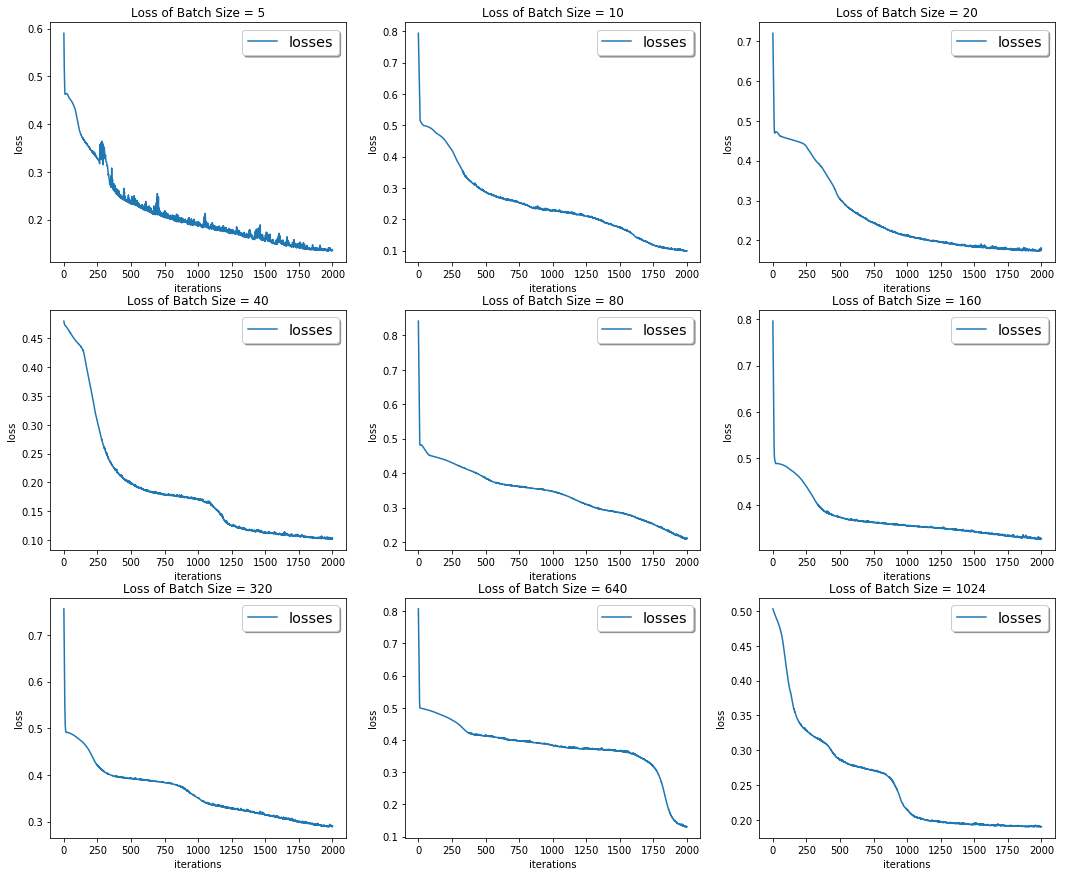

In [68]:
"""
        plots of batch size effect
"""
from matplotlib import pyplot as plt
batch_sizes = [5,10, 20,40,80,160,320,640,1024]

for i in range(9):
    
    lossData, neuronData = batchSizeEffectData[i].logData()
    # neuronData is not used here --> last part neuron graph
    
    plt.subplot(3, 3, i+1)
    plt.plot(lossData, label='losses')
    plt.title('Loss of Batch Size = {}'.format(batch_sizes[i]))
    plt.legend(prop={'size':  30}, shadow=True, fontsize='x-large', loc='lower left')
    legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.xlabel('iterations')
    plt.ylabel('loss')

plt.gcf().set_size_inches(18, 15)
plt.show()
    


In [202]:
"""

        Number of epochs effect
        L1loss
        
"""
inputs, targets = binarySampleVsParity(800, 10)

input_dim = 1
hidden_size_net = 10
num_layers = 1

numberOfEpochsEffect = []
epochs = [5,10,20,40,80,160,320,640,1024]
learning_rate = 0.003

for i in range(9):
    print("\nplease wait ... we are training ...")
    numberOfEpochsEffect.append(ParityRecursiveNeuralNetwork(input_dim, hidden_size_net, 1))
    numberOfEpochsEffect[i].train(inputs, targets, epochs[i], learning_rate)
print("training finished")   
    



please wait ... we are training ...

 learningData: 0.003
 batch size =  800 
 epoches =  5
hidden size =  10

please wait ... we are training ...

 learningData: 0.003
 batch size =  800 
 epoches =  10
hidden size =  10

please wait ... we are training ...

 learningData: 0.003
 batch size =  800 
 epoches =  20
hidden size =  10

please wait ... we are training ...

 learningData: 0.003
 batch size =  800 
 epoches =  40
hidden size =  10

please wait ... we are training ...

 learningData: 0.003
 batch size =  800 
 epoches =  80
hidden size =  10

please wait ... we are training ...

 learningData: 0.003
 batch size =  800 
 epoches =  160
hidden size =  10

please wait ... we are training ...

 learningData: 0.003
 batch size =  800 
 epoches =  320
hidden size =  10

please wait ... we are training ...

 learningData: 0.003
 batch size =  800 
 epoches =  640
hidden size =  10

please wait ... we are training ...

 learningData: 0.003
 batch size =  800 
 epoches =  1024
hidden

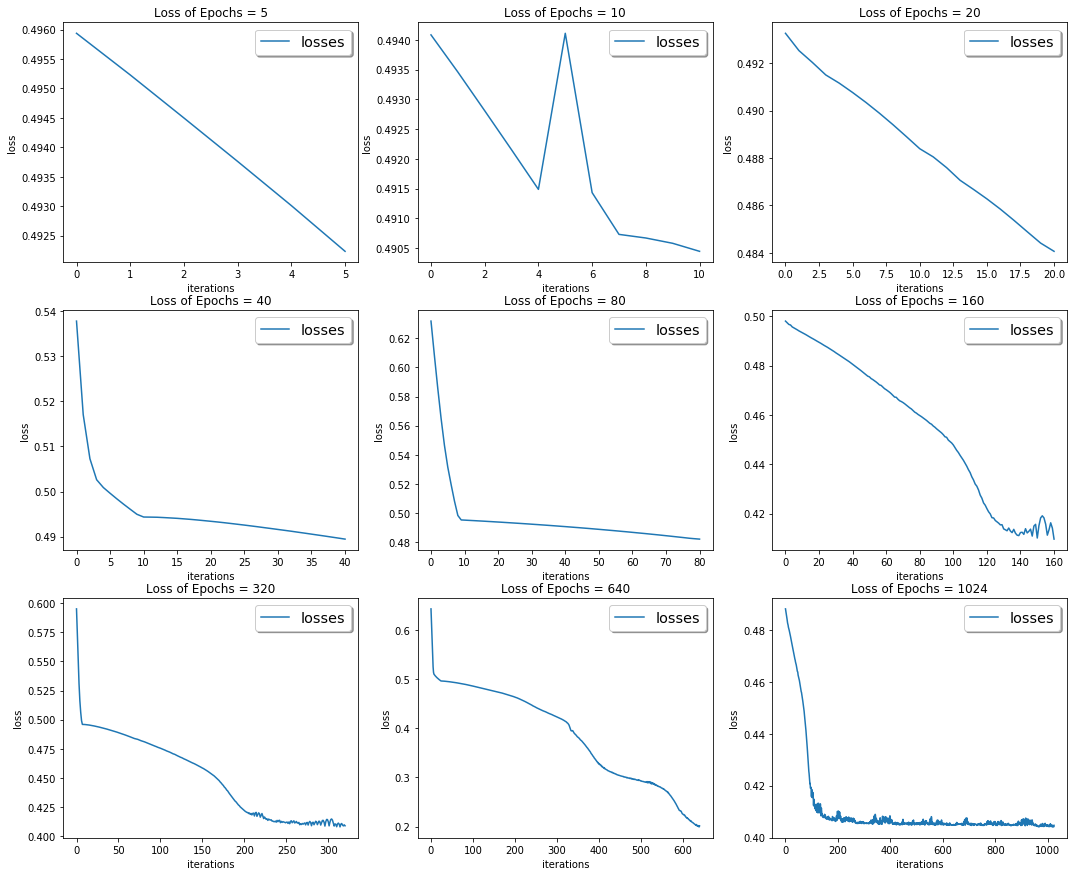

In [71]:
"""
        plots of epochs effect
"""
from matplotlib import pyplot as plt


for i in range(9):
    
    lossData, neuronData = numberOfEpochsEffect[i].logData()
    plt.subplot(3, 3, i+1)
    plt.plot(lossData, label='losses')
    plt.title('Loss of Epochs = {}'.format(epochs[i]))
    plt.legend(prop={'size':  30}, shadow=True, fontsize='x-large', loc='lower left')
    legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.xlabel('iterations')
    plt.ylabel('loss')

    
    
plt.gcf().set_size_inches(18, 15)
plt.show()
    


In [72]:
"""

        Hidden size effect
        L1loss
        
"""
inputs, targets = binarySampleVsParity(800, 10)

inpSim = 1
hidSize = [1,2,4,8,16,32,64,128,256]
numLayers = 1

hiddenSizeEffect = []
epoches = 2000
learning_rate = 0.01

for i in range(9):
    hiddenSizeEffect.append(ParityRecursiveNeuralNetwork(inpSize, hidSize[i], 1))
    hiddenSizeEffect[i].train(inputs, targets, epoches, learning_rate)



 learningData: 0.01
 batch size =  800 
 epoches =  2000
hidden size =  1

 learningData: 0.01
 batch size =  800 
 epoches =  2000
hidden size =  2

 learningData: 0.01
 batch size =  800 
 epoches =  2000
hidden size =  4

 learningData: 0.01
 batch size =  800 
 epoches =  2000
hidden size =  8

 learningData: 0.01
 batch size =  800 
 epoches =  2000
hidden size =  16

 learningData: 0.01
 batch size =  800 
 epoches =  2000
hidden size =  32

 learningData: 0.01
 batch size =  800 
 epoches =  2000
hidden size =  64

 learningData: 0.01
 batch size =  800 
 epoches =  2000
hidden size =  128

 learningData: 0.01
 batch size =  800 
 epoches =  2000
hidden size =  256


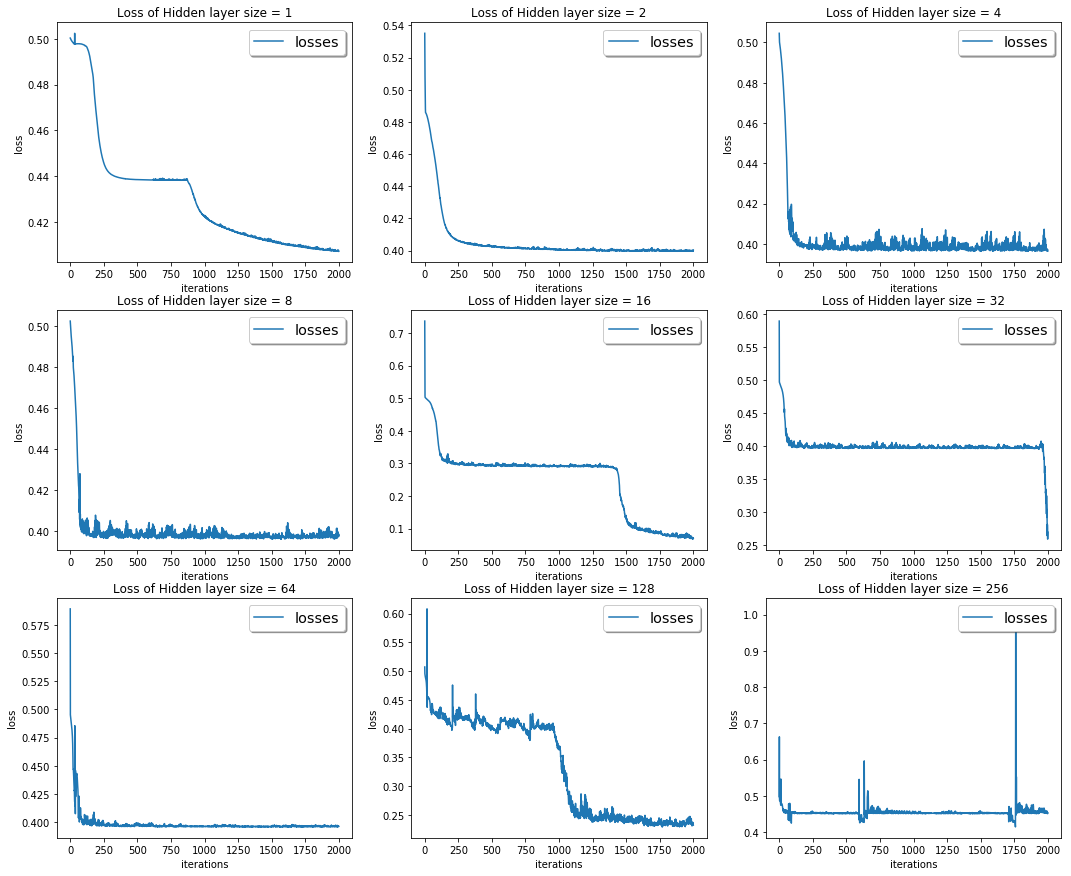

In [73]:
"""
        plots of hidden layer size effect
"""
from matplotlib import pyplot as plt

for i in range(9):
    
    lossData, neuronData = hiddenSizeEffect[i].logData()
    plt.subplot(3, 3, i+1)
    plt.plot(lossData, label='losses')
    plt.title('Loss of Hidden layer size = {}'.format(hidden_size_net[i]))
    plt.legend(prop={'size':  30}, shadow=True, fontsize='x-large', loc='lower left')
    legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.xlabel('iterations')
    plt.ylabel('loss')

    
plt.gcf().set_size_inches(18, 15)
plt.show()
    



number of hiddenLayer Size:  32


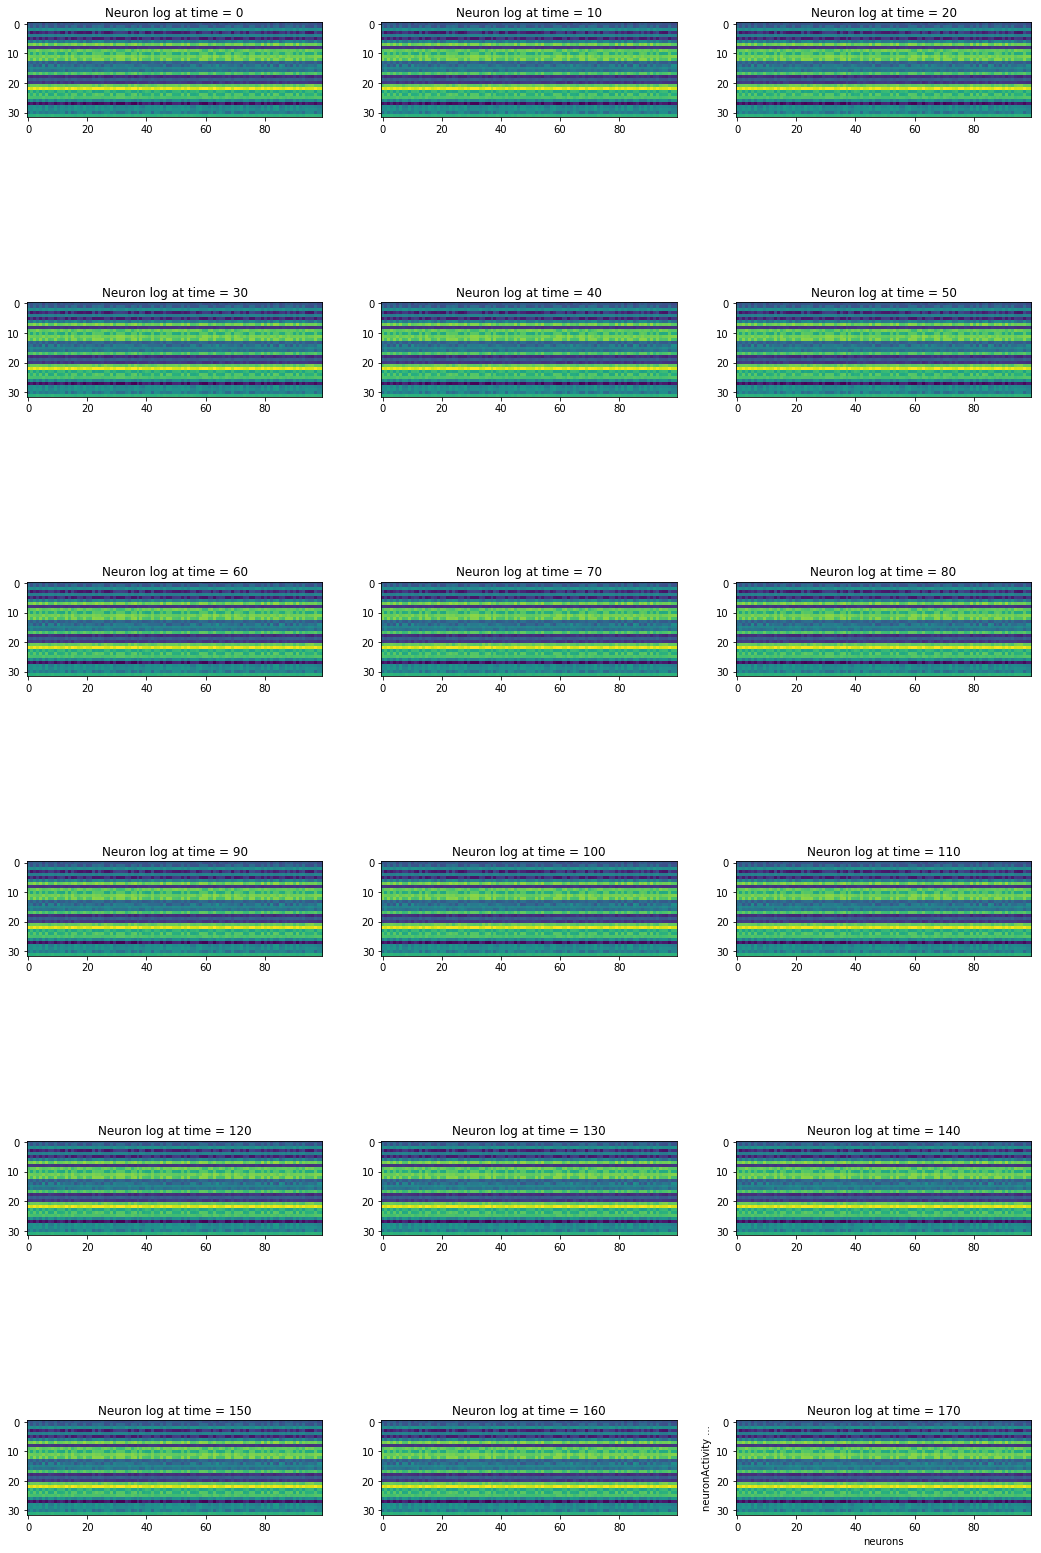

number of hiddenLayer Size:  64


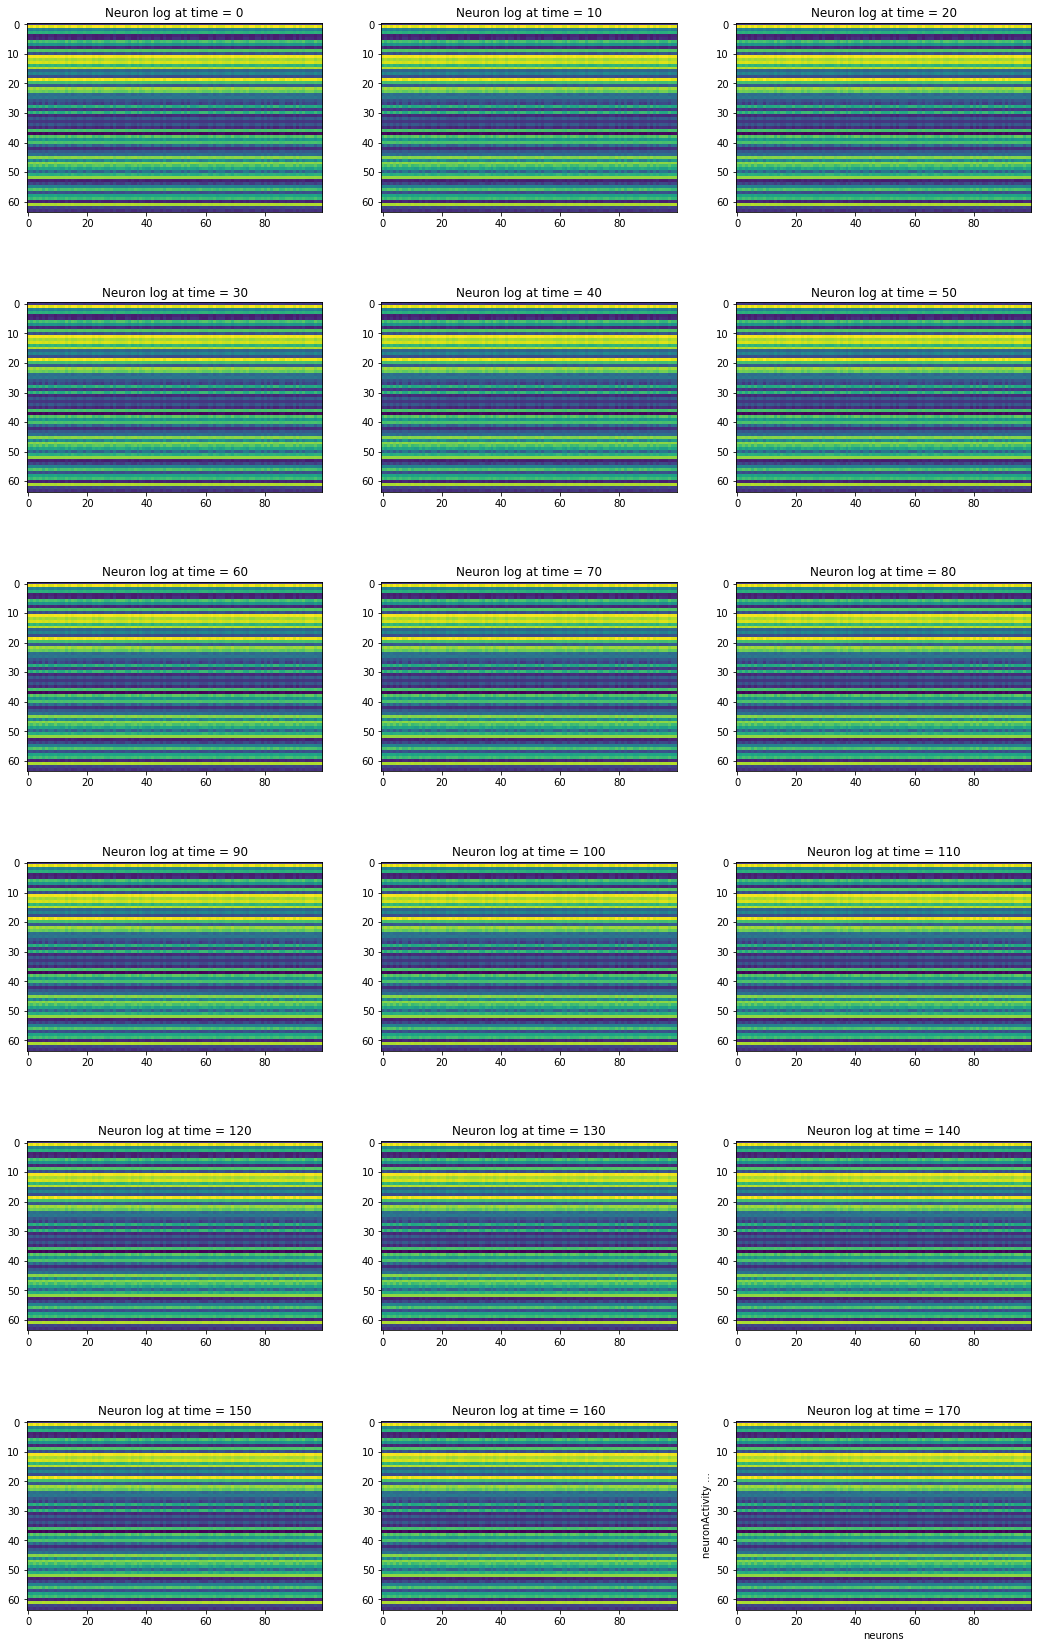

number of hiddenLayer Size:  128


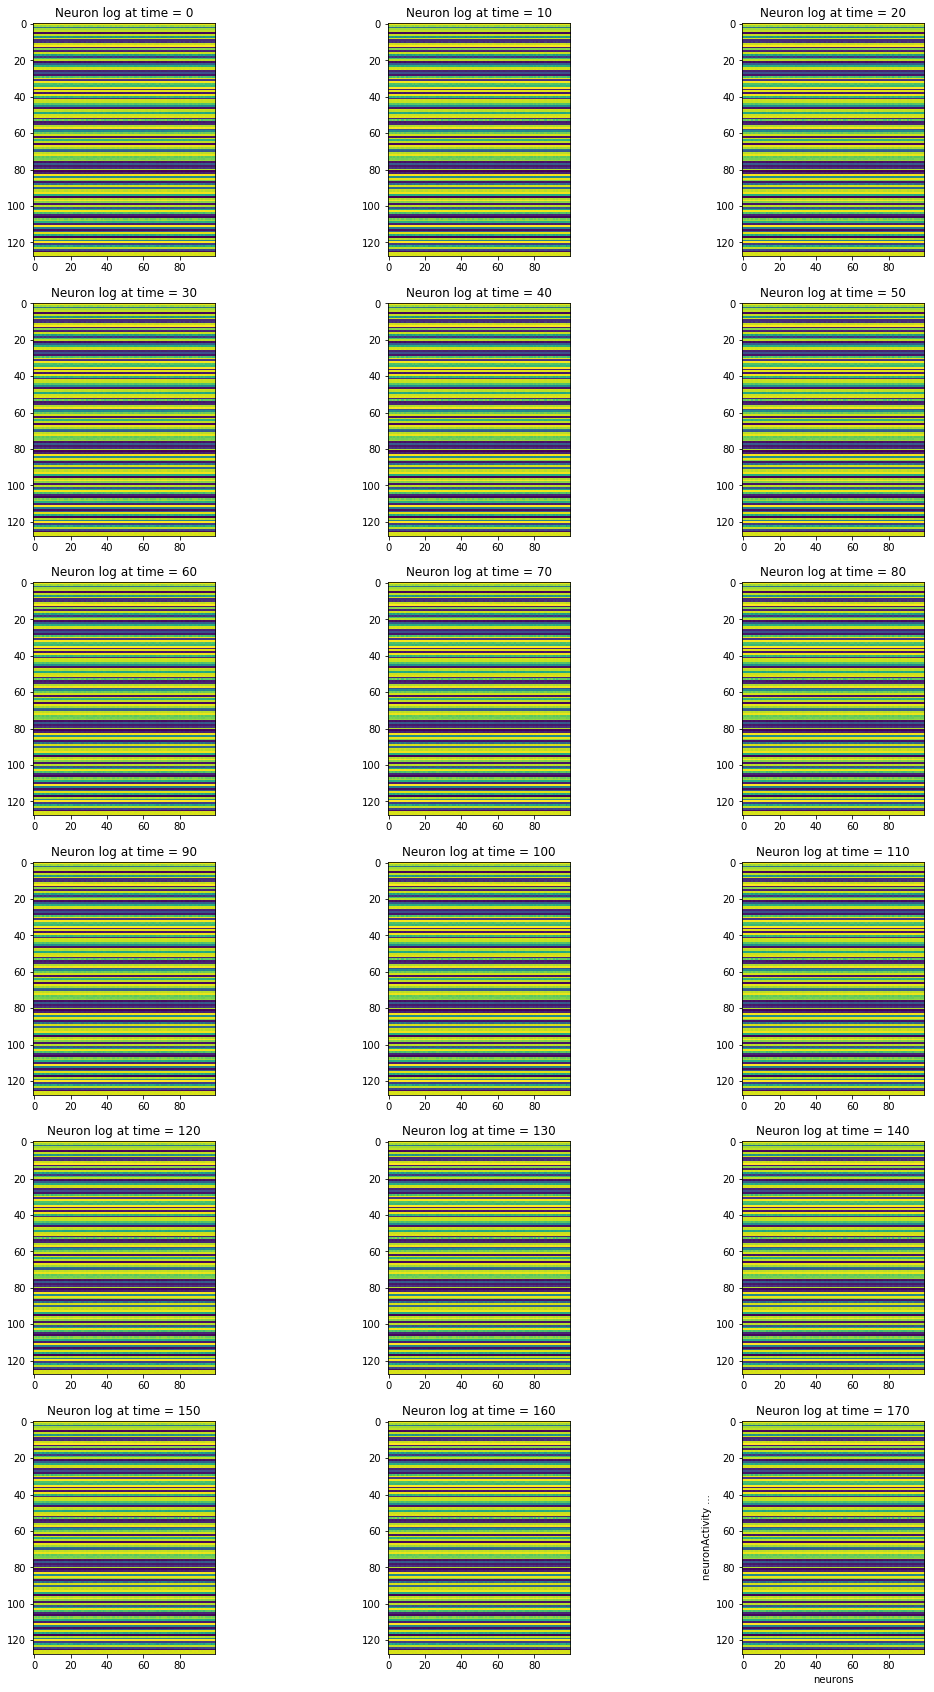

number of hiddenLayer Size:  256


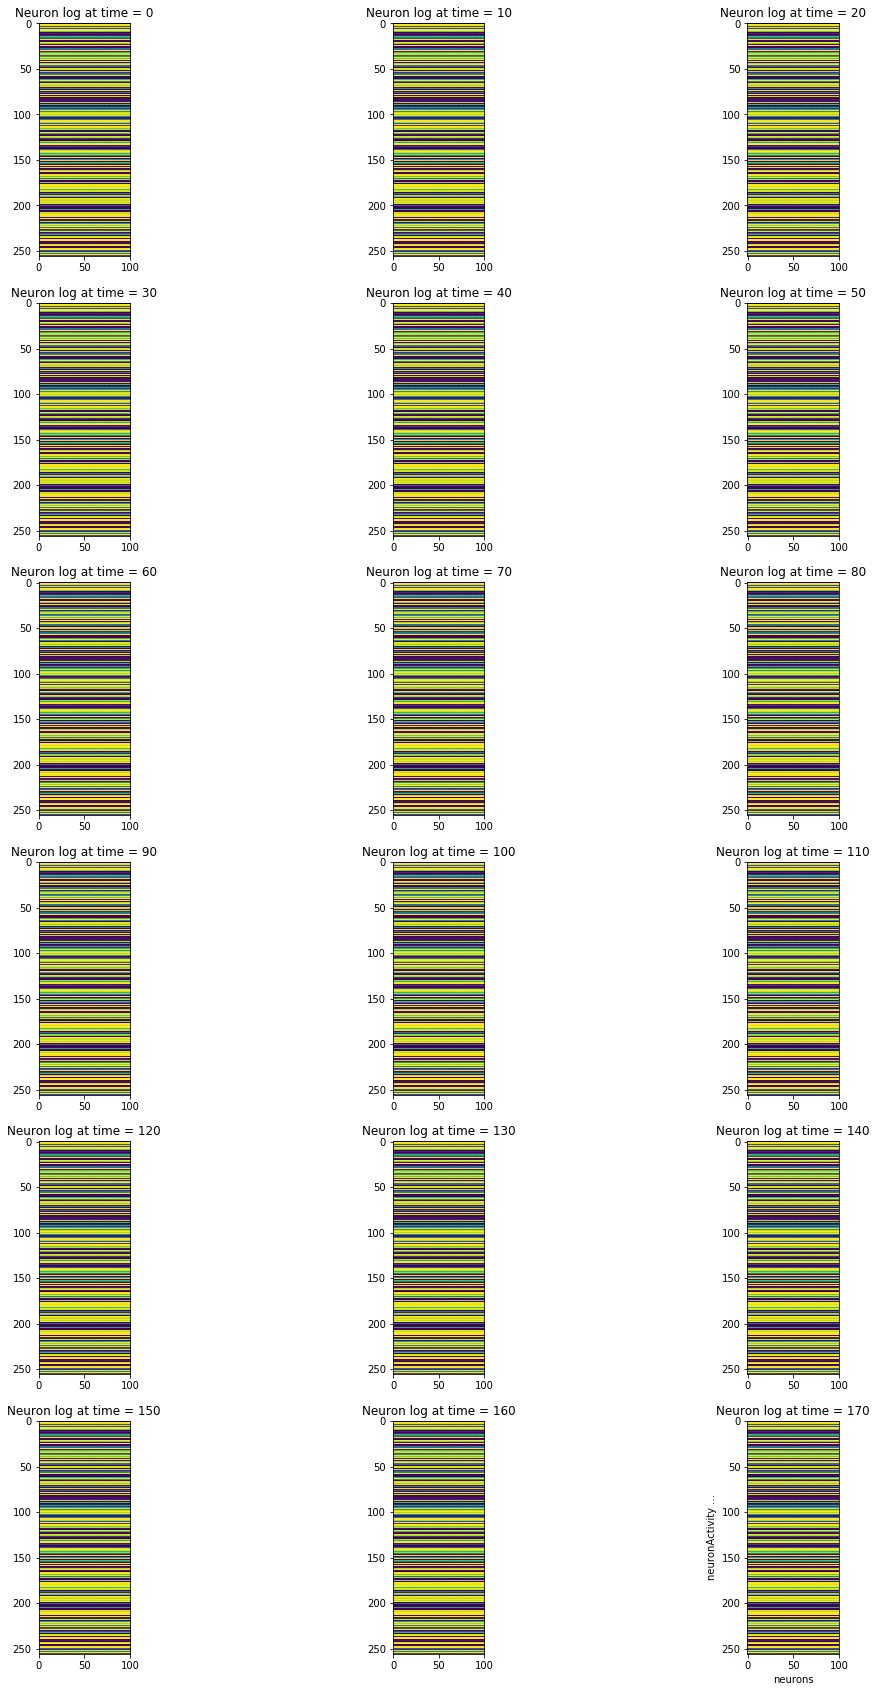

In [199]:

"""
    
    Neurons activity log
    in each part !!!
    
"""

from matplotlib import pyplot as plt

#def drawN(NNData,randomAccess):
    
for i in range(5,9):
    drawN(hiddenSizeEffect,i)
    plt.gcf().set_size_inches(18,30)
    plt.xlabel("neurons")
    plt.ylabel("neuronActivity ...")
    plt.show()  

def drawN(NNData,randomAccess):
    lossData, neuronData = NNData[randomAccess].logData()
    neuronDatas = []
    print("number of hiddenLayer Size: ",hidden_size_net[randomAccess])
    for neuron in neuronData:
        # k = k.data.numpy()
        neuronDatas.append(neuron)
        # it should has three dimension so i concatinate it via third dimensoin via entities of zero ...    
    neuronDatas = np.concatenate(neuronDatas, 0)

    for j in range(18):    
        plt.subplot(6, 3, j+1)
        plt.imshow(np.transpose(neuronDatas[i][:100]), label='losses')
        plt.title('Neuron log at time = {}'.format(j*10))
